In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
sns.set_style("darkgrid")

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
# pd.reset_option(‘max_columns’)

import warnings
warnings.filterwarnings("default")

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
df_shootouts = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'shootouts.csv'), parse_dates=['date'])
df_shootouts = df_shootouts.sort_values('date', ascending=True).reset_index(drop=True)
df_shootouts = df_shootouts[df_shootouts['date'] < '2022']
df_shootouts

,date,home_team,away_team,winner
0,1967-08-22,India,Taiwan,Taiwan
1,1971-11-14,South Korea,Vietnam Republic,South Korea
2,1972-05-17,Thailand,South Korea,South Korea
3,1972-05-19,Thailand,Cambodia,Thailand
4,1973-07-26,Malaysia,Kuwait,Malaysia
...,...,...,...,...
445,2021-07-18,Eswatini,Mozambique,Eswatini
446,2021-07-18,South Africa,Senegal,South Africa
447,2021-11-19,Sri Lanka,Seychelles,Seychelles
448,2021-12-11,Morocco,Algeria,Algeria


In [4]:
df_results = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'results.csv'), parse_dates=['date'])
df_results = df_results.sort_values('date', ascending=True).reset_index(drop=True)
df_results['year'] = pd.DatetimeIndex(df_results['date']).year
df_results = df_results[df_results['year'] < 2022]
df_results['score_sum'] = df_results['home_score'] + df_results['away_score']
df_results['score_diff'] = df_results['home_score'] - df_results['away_score']
df_results['score_diff_abs'] = np.abs(df_results['score_diff'])

In [5]:
def get_shootout_winner(row, df_shootouts=df_shootouts):
    winner_filter = ((row['date'] == df_shootouts['date']) & (row['home_team'] == df_shootouts['home_team']) & (row['away_team'] == df_shootouts['away_team']))
    if winner_filter.sum() == 0:
        return 'tie'
    if winner_filter.sum() > 1:
        return 'error: multiple shootouts for the same match'
    else:
        winning_country = df_shootouts.loc[winner_filter, 'winner'].iloc[0]
        winner = 'home_team' if winning_country == row['home_team'] else 'away_team' if winning_country == row['away_team'] else 'error: team not found'
        return winner

In [6]:
df_results['winner'] = df_results.apply(lambda row: 'home_team' if row['score_diff'] > 0 else 'away_team' if row['score_diff'] < 0 else 'tie', axis=1)
df_results['winner_including_shootouts'] = df_results['winner']
df_results.loc[df_results['winner'] == 'tie', 'winner_including_shootouts'] = df_results[df_results['winner'] == 'tie'].apply(get_shootout_winner, axis=1)

In [7]:
df_confederations = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'contry-to-confederation.csv'), delimiter=';')
df_confederations.set_index('country', inplace=True)
df_confederations

,confederation
country,
Afghanistan,AFC
Australia,AFC
Bahrain,AFC
Bangladesh,AFC
Bhutan,AFC
...,...
Sweden,UEFA
Switzerland,UEFA
Turkey,UEFA


In [8]:
df_results = df_results.join(df_confederations, on='country', how='left')
df_results.loc[df_results['confederation'].isna(), 'confederation'] = 'N/A'

df_results = df_results.join(df_confederations, on='home_team', how='left', rsuffix='_home_team')
df_results.loc[df_results['confederation_home_team'].isna(), 'confederation_home_team'] = 'N/A'

df_results = df_results.join(df_confederations, on='away_team', how='left', rsuffix='_away_team')
df_results.loc[df_results['confederation_away_team'].isna(), 'confederation_away_team'] = 'N/A'

df_results.rename(columns={'confederation':'confederation_host_country'}, inplace=True)

In [9]:
confederations = {
    'AFC': 'AFC - Asian Football Confederation in Asia and Australia',
    'CAF': 'CAF - Confédération Africaine de Football in Africa',
    'CONCACAF': 'CONCACAF - Confederation of North, Central American and Caribbean Association Football in North America and Central America',
    'CONMEBOL': 'CONMEBOL - Confederación Sudamericana de Fútbol in South America',
    'OFC': 'OFC - Oceania Football Confederation in Oceania',
    'UEFA': 'UEFA - Union of European Football Associations in Europe'
}

In [10]:
conf_to_continent = {
    'AFC': 'AFC (Asia and Australia)',
    'CAF': 'CAF (Africa)',
    'CONCACAF': 'CONCACAF (North and Central America)',
    'CONMEBOL': 'CONMEBOL (South America)',
    'OFC': 'OFC (Oceania)',
    'UEFA': 'UEFA (Europe)',
    'N/A': 'N/A'
}

In [11]:
df_results['confederation_host_country'] = df_results['confederation_host_country'].apply(lambda cell: conf_to_continent[cell])
df_results['confederation_home_team'] = df_results['confederation_home_team'].apply(lambda cell: conf_to_continent[cell])
df_results['confederation_away_team'] = df_results['confederation_away_team'].apply(lambda cell: conf_to_continent[cell])
df_results

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,score_sum,score_diff,score_diff_abs,winner,winner_including_shootouts,confederation_host_country,confederation_home_team,confederation_away_team
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,0,0,0,tie,tie,UEFA (Europe),UEFA (Europe),UEFA (Europe)
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873,6,2,2,home_team,home_team,UEFA (Europe),UEFA (Europe),UEFA (Europe)
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,3,1,1,home_team,home_team,UEFA (Europe),UEFA (Europe),UEFA (Europe)
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875,4,0,0,tie,tie,UEFA (Europe),UEFA (Europe),UEFA (Europe)
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,3,3,3,home_team,home_team,UEFA (Europe),UEFA (Europe),UEFA (Europe)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43102,2021-12-18,Qatar,Egypt,0,0,Arab Cup,Doha,Qatar,False,2021,0,0,0,tie,home_team,AFC (Asia and Australia),AFC (Asia and Australia),CAF (Africa)
43103,2021-12-18,United States,Bosnia and Herzegovina,1,0,Friendly,Los Angeles,United States,False,2021,1,1,1,home_team,home_team,CONCACAF (North and Central America),CONCACAF (North and Central America),UEFA (Europe)
43104,2021-12-30,Mauritania,Burkina Faso,0,0,Friendly,Abu Dhabi,United Arab Emirates,True,2021,0,0,0,tie,tie,AFC (Asia and Australia),CAF (Africa),CAF (Africa)
43105,2021-12-30,Sudan,Ethiopia,2,3,Friendly,Limbé,Cameroon,True,2021,5,-1,1,away_team,away_team,CAF (Africa),CAF (Africa),CAF (Africa)


In [12]:
df_results[df_results['confederation_home_team'] == 'N/A']['home_team'].unique()

array(['Czechoslovakia', 'Catalonia', 'Basque Country', 'Brittany',
       'Yugoslavia', 'Galicia', 'Andalusia', 'Central Spain', 'Silesia',
       'Manchukuo', 'DR Congo', 'German DR', 'Kernow', 'Saarland',
       'Vietnam Republic', 'North Vietnam', 'Taiwan', 'Eswatini',
       'Western Australia', 'Yemen DPR', 'Northern Cyprus',
       'Wallis Islands and Futuna', 'Brunei', 'Greenland', 'Palau',
       'Åland Islands', 'Ynys Môn', 'Jersey', 'Shetland', 'Isle of Wight',
       'Guernsey', 'Isle of Man', 'North Macedonia', 'Canary Islands',
       'Frøya', 'Hitra', 'United States Virgin Islands', 'Corsica',
       'Gotland', 'Saare County', 'Rhodes', 'Micronesia', 'Orkney',
       'Monaco', 'Sark', 'Alderney', 'Mayotte', 'Western Isles',
       'Falkland Islands', 'Republic of St. Pauli', 'Găgăuzia', 'Tibet',
       'Occitania', 'Sápmi', 'Menorca', 'Provence', 'Arameans Suryoye',
       'Padania', 'Iraqi Kurdistan', 'Gozo', 'Darfur', 'Western Sahara',
       'Raetia', 'Tamil Eelam', '

In [13]:
#check data types
df_results.dtypes

date                          datetime64[ns]
home_team                             object
away_team                             object
home_score                             int64
away_score                             int64
tournament                            object
city                                  object
country                               object
neutral                                 bool
year                                   int64
score_sum                              int64
score_diff                             int64
score_diff_abs                         int64
winner                                object
winner_including_shootouts            object
confederation_host_country            object
confederation_home_team               object
confederation_away_team               object
dtype: object

In [14]:
# check for missing values
df_results.isna().sum()

date                          0
home_team                     0
away_team                     0
home_score                    0
away_score                    0
tournament                    0
city                          0
country                       0
neutral                       0
year                          0
score_sum                     0
score_diff                    0
score_diff_abs                0
winner                        0
winner_including_shootouts    0
confederation_host_country    0
confederation_home_team       0
confederation_away_team       0
dtype: int64

In [15]:
df_results['winner'].value_counts()

home_team    20967
away_team    12206
tie           9934
Name: winner, dtype: int64

In [16]:
df_results['winner_including_shootouts'].value_counts()

home_team    21191
away_team    12403
tie           9513
Name: winner_including_shootouts, dtype: int64

## 1. Football Growth Overall

In [17]:
countries = np.sort(pd.unique(df_results[['home_team', 'away_team']].values.ravel('K')))

In [18]:
fifa_wc_years = [1930, 1934, 1938] + list(range(1950, 2022, 4))

### 1.1. Number of International Matches

In [19]:
s_num_matches = df_results[['home_team', 'year']].groupby('year').count()['home_team']
s_num_matches.name = 'num_matches'
s_num_matches

year
1872       1
1873       1
1874       1
1875       1
1876       2
        ... 
2017     958
2018     908
2019    1156
2020     299
2021    1086
Name: num_matches, Length: 150, dtype: int64

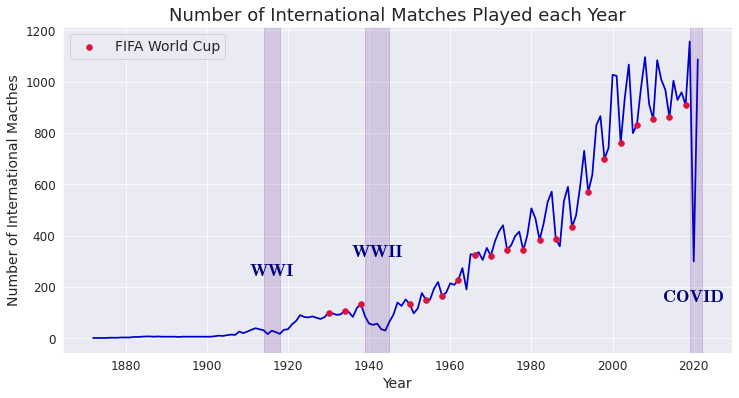

In [20]:
plt.figure(figsize=(12,6))

plt.plot(s_num_matches, color='mediumblue', linestyle='-', linewidth=1.75, zorder=1)
plt.scatter(x=fifa_wc_years, y=s_num_matches.loc[fifa_wc_years], color='crimson', label='FIFA World Cup', linewidth=0.5, zorder=2)

plt.title('Number of International Matches Played each Year', fontsize=BIGGER_SIZE)
plt.ylabel('Number of International Macthes')
plt.xlabel('Year')

plt.axvspan(1914, 1918, color='indigo', alpha=0.15)
plt.text(1916, 290, 'WWI', color='navy', horizontalalignment='center', verticalalignment='top', fontsize=18, fontname='cmb10')
plt.axvspan(1939, 1945, color='indigo', alpha=0.15)
plt.text(1942, 305, 'WWII', color='navy', horizontalalignment='center', verticalalignment='bottom', fontsize=18, fontname='cmb10')
plt.axvspan(2019, 2022, color='indigo', alpha=0.15)
plt.text(2020, 190, 'COVID', color='navy', horizontalalignment='center', verticalalignment='top', fontsize=18, fontname='cmb10')


plt.legend(frameon=True, loc='upper left', ncol=1, fontsize=14)

plt.savefig('../graphs/1-1_num-intl-matches.png', dpi=200, bbox_inches='tight', pad_inches=0.3, facecolor='white', transparent=False)

plt.show()

### 1.2. Number of Unique International Teams

In [21]:
s_num_teams = df_results[['home_team', 'away_team', 'year']].groupby('year').apply(lambda row: len(pd.unique(pd.concat([row['home_team'], row['away_team']], axis=0))))
# s_num_teams

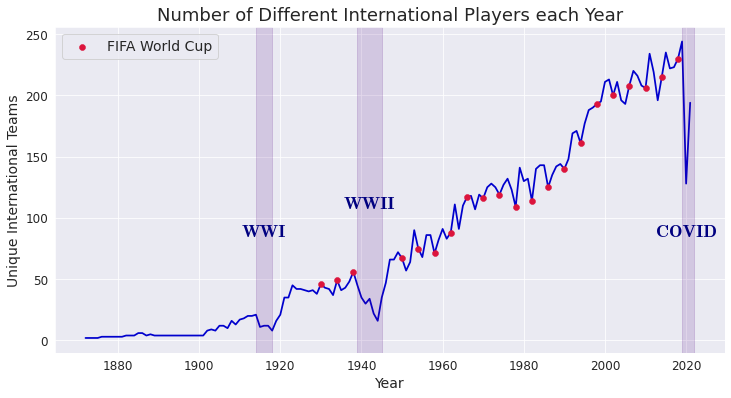

In [22]:
plt.figure(figsize=(12,6))

plt.plot(s_num_teams, color='mediumblue', linestyle='-', linewidth=1.75, zorder=1)
plt.scatter(x=fifa_wc_years, y=s_num_teams.loc[fifa_wc_years], color='crimson', label='FIFA World Cup', linewidth=0.5, zorder=2)

plt.title('Number of Different International Players each Year', fontsize=BIGGER_SIZE)
plt.ylabel('Unique International Teams')
plt.xlabel('Year')

plt.axvspan(1914, 1918, color='indigo', alpha=0.15)
plt.text(1916, 95, 'WWI', color='navy', horizontalalignment='center', verticalalignment='top', fontsize=18, fontname='cmb10')
plt.axvspan(1939, 1945, color='indigo', alpha=0.15)
plt.text(1942, 105, 'WWII', color='navy', horizontalalignment='center', verticalalignment='bottom', fontsize=18, fontname='cmb10')
plt.axvspan(2019, 2022, color='indigo', alpha=0.15)
plt.text(2020, 95, 'COVID', color='navy', horizontalalignment='center', verticalalignment='top', fontsize=18, fontname='cmb10')


plt.legend(frameon=True, loc='upper left', ncol=1, fontsize=14)

plt.savefig('../graphs/1-2_num-intl-teams.png', dpi=200, bbox_inches='tight', pad_inches=0.3, facecolor='white', transparent=False)

plt.show()

## 2. Football Growth per Hosting Confederation

### 2.1. Number of International Matches per Hosting Confederation

In [23]:
s_num_matches_conf = df_results[['confederation_host_country', 'year', 'home_team']].groupby(['confederation_host_country', 'year']).count()['home_team']
s_num_matches_conf.name = 'num_matches_per_confederation_host'
s_num_matches_conf

confederation_host_country  year
AFC (Asia and Australia)    1917      1
                            1921      1
                            1923      5
                            1924      6
                            1925      2
                                   ... 
UEFA (Europe)               2017    309
                            2018    429
                            2019    335
                            2020    230
                            2021    405
Name: num_matches_per_confederation_host, Length: 750, dtype: int64

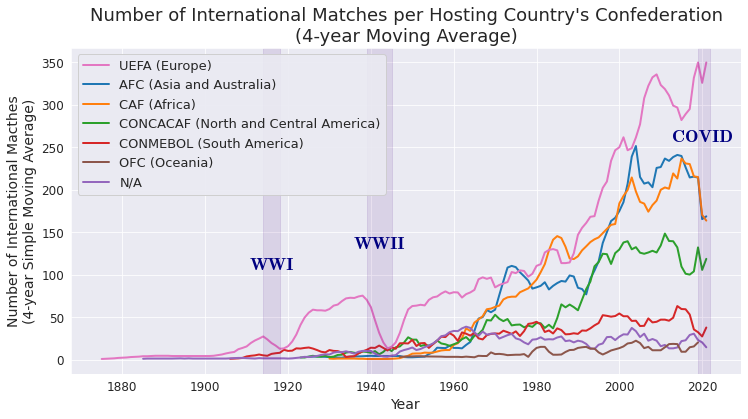

In [24]:
plt.figure(figsize=(12,6))

for conf in np.sort(s_num_matches_conf.index.get_level_values(0).unique()):
    plt.plot(s_num_matches_conf.loc[conf].rolling(4).mean(), label=conf, linestyle='-', linewidth=2, zorder=1)


plt.title("Number of International Matches per Hosting Country's Confederation\n(4-year Moving Average)", fontsize=BIGGER_SIZE)
plt.ylabel('Number of International Macthes\n(4-year Simple Moving Average)')
plt.xlabel('Year')

plt.axvspan(1914, 1918, color='indigo', alpha=0.1)
plt.text(1916, 103, 'WWI', color='navy', horizontalalignment='center', verticalalignment='bottom', fontsize=18, fontname='cmb10')
plt.axvspan(1939, 1945, color='indigo', alpha=0.1)
plt.text(1942, 145, 'WWII', color='navy', horizontalalignment='center', verticalalignment='top', fontsize=18, fontname='cmb10')
plt.axvspan(2019, 2022, color='indigo', alpha=0.1)
plt.text(2020, 253, 'COVID', color='navy', horizontalalignment='center', verticalalignment='bottom', fontsize=18, fontname='cmb10')

handles, labels = plt.gca().get_legend_handles_labels()
order=[6,0,1,2,3,5,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=True, loc='upper left', ncol=1, fontsize=13, framealpha=0.9)

plt.savefig('../graphs/2-1_num-intl-matches-per-conf.png', dpi=200, bbox_inches='tight', pad_inches=0.3, facecolor='white', transparent=False)

plt.show()

### 2.2. Number of Unique International Teams per Confederation

In [25]:
s_num_teams_conf_unique_home = df_results[['confederation_home_team', 'year', 'home_team']].groupby(['confederation_home_team', 'year']).apply(lambda row: pd.unique(row['home_team']))
s_num_teams_conf_unique_home.name = 'unique_home'
# s_num_teams_conf_unique_home

In [26]:
s_num_teams_conf_unique_away = df_results[['confederation_away_team', 'year', 'away_team']].groupby(['confederation_away_team', 'year']).apply(lambda row: pd.unique(row['away_team']))
s_num_teams_conf_unique_away.name = 'unique_away'
# s_num_teams_conf_unique_away

In [27]:
df_num_teams_conf_unique = pd.concat([s_num_teams_conf_unique_home, s_num_teams_conf_unique_away], axis=1).sort_index()
df_num_teams_conf_unique.loc[df_num_teams_conf_unique['unique_home'].isna(), 'unique_home'] = df_num_teams_conf_unique[df_num_teams_conf_unique['unique_home'].isna()]['unique_away']
df_num_teams_conf_unique.loc[df_num_teams_conf_unique['unique_away'].isna(), 'unique_away'] = df_num_teams_conf_unique[df_num_teams_conf_unique['unique_away'].isna()]['unique_home']
s_num_teams_conf_unique = df_num_teams_conf_unique.apply(lambda row: np.concatenate([row['unique_home'], row['unique_away']]), axis=1)
s_num_teams_conf_unique

                          year
AFC (Asia and Australia)  1917                                 [Japan, Philippines]
                          1921                                 [Japan, Philippines]
                          1922                               [Australia, Australia]
                          1923    [China PR, Japan, Australia, Philippines, Chin...
                          1924                               [Australia, Australia]
                                                        ...                        
UEFA (Europe)             2017    [Iceland, San Marino, Scotland, Czech Republic...
                          2018    [Estonia, Denmark, Moldova, Azerbaijan, Latvia...
                          2019    [Finland, Estonia, Iceland, Kazakhstan, German...
                          2020    [Moldova, Kosovo, Faroe Islands, Latvia, Slove...
                          2021    [Gibraltar, Latvia, Malta, Slovenia, Cyprus, T...
Length: 738, dtype: object

In [28]:
s_num_teams_conf = pd.Series(index=s_num_teams_conf_unique.index, dtype=pd.Int64Dtype)
for conf in np.sort(s_num_teams_conf_unique.index.get_level_values(0).unique()):
    conf_unique_teams = set([])
    
    for year, teams in s_num_teams_conf_unique.loc[conf].items():
        conf_unique_teams.update(teams)
        s_num_teams_conf.loc[(conf, year)] = len(conf_unique_teams)
    conf_unique_teams.clear()
    
s_num_teams_conf

                          year
AFC (Asia and Australia)  1917     2.0
                          1921     2.0
                          1922     3.0
                          1923     4.0
                          1924     4.0
                                  ... 
UEFA (Europe)             2017    54.0
                          2018    54.0
                          2019    54.0
                          2020    54.0
                          2021    54.0
Length: 738, dtype: float64

In [29]:
df_results[df_results['home_team'].isin(['Crimea']) | df_results['away_team'].isin(['Crimea'])]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,score_sum,score_diff,score_diff_abs,winner,winner_including_shootouts,confederation_host_country,confederation_home_team,confederation_away_team
28940,2006-11-19,Northern Cyprus,Crimea,5,0,ELF Cup,Lefkoşa,Northern Cyprus,False,2006,5,5,5,home_team,home_team,N/A,N/A,N/A
28941,2006-11-20,Tibet,Crimea,0,1,ELF Cup,Güzelyurt,Northern Cyprus,True,2006,1,-1,1,away_team,away_team,N/A,N/A,N/A
28951,2006-11-21,Tajikistan,Crimea,1,2,ELF Cup,Gazimağusa,Northern Cyprus,True,2006,3,-1,1,away_team,away_team,N/A,AFC (Asia and Australia),N/A
28953,2006-11-23,Kyrgyzstan,Crimea,2,3,ELF Cup,Lefkoşa,Northern Cyprus,True,2006,5,-1,1,away_team,away_team,N/A,AFC (Asia and Australia),N/A
28961,2006-11-25,Northern Cyprus,Crimea,3,1,ELF Cup,Lefkoşa,Northern Cyprus,False,2006,4,2,2,home_team,home_team,N/A,N/A,N/A


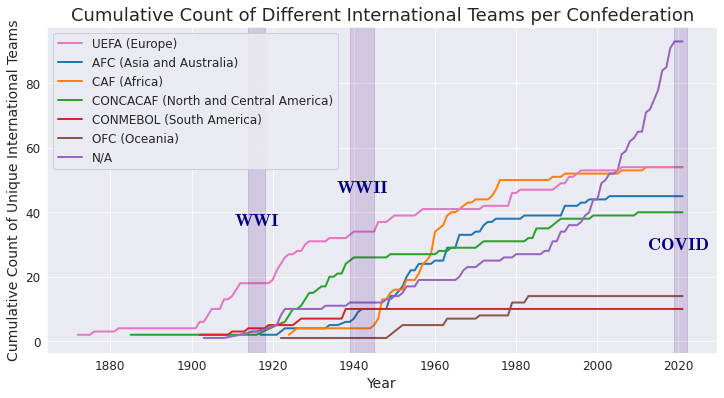

In [30]:
plt.figure(figsize=(12,6))

for conf in np.sort(s_num_teams_conf.index.get_level_values(0).unique()):
    plt.plot(s_num_teams_conf.loc[conf], label=conf, linestyle='-', linewidth=2, zorder=1)

plt.title("Cumulative Count of Different International Teams per Confederation", fontsize=BIGGER_SIZE)
plt.ylabel('Cumulative Count of Unique International Teams')
plt.xlabel('Year')

plt.axvspan(1914, 1918, color='indigo', alpha=0.15)
plt.text(1916, 35, 'WWI', color='navy', horizontalalignment='center', verticalalignment='bottom', fontsize=18, fontname='cmb10')
plt.axvspan(1939, 1945, color='indigo', alpha=0.15)
plt.text(1942, 50, 'WWII', color='navy', horizontalalignment='center', verticalalignment='top', fontsize=18, fontname='cmb10')
plt.axvspan(2019, 2022, color='indigo', alpha=0.15)
plt.text(2020, 30, 'COVID', color='navy', horizontalalignment='center', verticalalignment='center', fontsize=18, fontname='cmb10')


handles, labels = plt.gca().get_legend_handles_labels()
order=[6,0,1,2,3,5,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=True, loc='upper left', ncol=1, fontsize=12, framealpha=0.9)

plt.savefig('../graphs/2-2_count-intl-teams-per-conf.png', dpi=200, bbox_inches='tight', pad_inches=0.3, facecolor='white', transparent=False)

plt.show()

## 3. Playing Style Evolution

### 3.1. Evolution of Score Sums and Differences

In [31]:
s_avg_score_diff = df_results[['year', 'score_diff_abs']].groupby('year').agg('mean')['score_diff_abs']
s_avg_score_diff.name = 'avg_score_diff'
s_avg_score_diff

year
1872    0.000000
1873    2.000000
1874    1.000000
1875    0.000000
1876    3.500000
          ...   
2017    1.535491
2018    1.602423
2019    1.827855
2020    1.321070
2021    1.754144
Name: avg_score_diff, Length: 150, dtype: float64

In [32]:
s_avg_score_sum = df_results[['year', 'score_sum']].groupby('year').agg('mean')['score_sum']
s_avg_score_sum.name = 'avg_score_sum'
s_avg_score_sum

year
1872    0.000000
1873    6.000000
1874    3.000000
1875    4.000000
1876    3.500000
          ...   
2017    2.696242
2018    2.609031
2019    2.872837
2020    2.471572
2021    2.737569
Name: avg_score_sum, Length: 150, dtype: float64

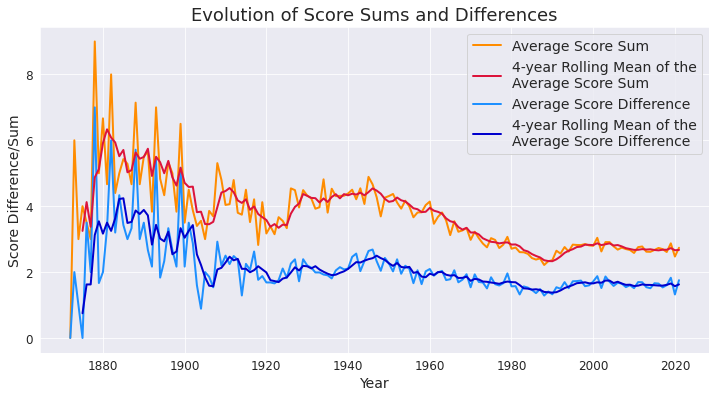

In [33]:
plt.figure(figsize=(12,6))

plt.plot(s_avg_score_sum, color='darkorange', label='Average Score Sum', linestyle='-', linewidth=2, zorder=1)
plt.plot(s_avg_score_sum.rolling(4).mean(), color='crimson', label='4-year Rolling Mean of the\nAverage Score Sum', linestyle='-', linewidth=2, zorder=2)

plt.plot(s_avg_score_diff, color='dodgerblue', label='Average Score Difference', linestyle='-', linewidth=2, zorder=1)
plt.plot(s_avg_score_diff.rolling(4).mean(), color='mediumblue', label='4-year Rolling Mean of the\nAverage Score Difference', linestyle='-', linewidth=2, zorder=2)

plt.title("Evolution of Score Sums and Differences", fontsize=BIGGER_SIZE)
plt.ylabel('Score Difference/Sum')
plt.xlabel('Year')


plt.legend(frameon=True, loc='upper right', ncol=1, fontsize=14)

plt.savefig('../graphs/3-1_evolution-scores.png', dpi=200, bbox_inches='tight', pad_inches=0.3, facecolor='white', transparent=False)

plt.show()

### 3.2. Evolution of Results

In [34]:
def parse_proportions(s_winners):
    s_winners = s_winners['value_counts']
    if len(s_winners) != 3:
        indexes = [t[0] for t in s_winners]
        for result in ['home_team', 'tie', 'away_team']:
            if result not in indexes:
                s_winners = pd.Series([*s_winners, (result, 0)])
    idx, values = zip(*s_winners)
    s_winners = pd.Series(values, idx)
    return s_winners

In [35]:
df_results[df_results['winner_including_shootouts'] != df_results['winner']].shape

(421, 18)

In [36]:
df_winner = df_results[['year', 'winner_including_shootouts']].groupby('year').agg(
value_counts = ('winner_including_shootouts', lambda x: [(var, val) for (var, val) in zip(x.value_counts().index, x.value_counts(normalize=True))])
)
df_winner = df_winner.apply(parse_proportions, axis=1)
df_winner = df_winner * 100
df_winner

,away_team,home_team,tie
year,,,
1872,0.000000,0.000000,100.000000
1873,0.000000,100.000000,0.000000
1874,0.000000,100.000000,0.000000
1875,0.000000,0.000000,100.000000
1876,0.000000,100.000000,0.000000
...,...,...,...
2017,28.079332,45.929019,25.991649
2018,28.524229,46.916300,24.559471
2019,30.449827,50.000000,19.550173


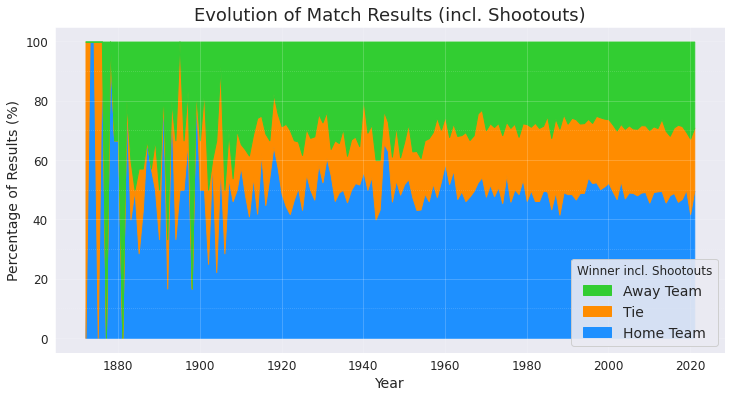

In [37]:
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(1, figsize=(12,6))

plt.fill_between(x=df_winner.index, y1=0, y2=df_winner['home_team'], color='dodgerblue', label='Home Team', zorder=0)
plt.fill_between(x=df_winner.index, y1=df_winner['home_team'], y2=df_winner['home_team']+df_winner['tie'], color='darkorange', label='Tie', zorder=0)
plt.fill_between(x=df_winner.index, y1=df_winner['home_team']+df_winner['tie'], y2=df_winner['home_team']+df_winner['tie']+df_winner['away_team'], color='limegreen', label='Away Team', zorder=0)

plt.title("Evolution of Match Results (incl. Shootouts)", fontsize=BIGGER_SIZE)
plt.ylabel('Percentage of Results (%)')
plt.xlabel('Year')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title='Winner incl. Shootouts', frameon=True, loc='lower right', ncol=1, fontsize=14, framealpha=0.9)

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth=0.75, color='white', alpha=0.25)
# Customize the minor grid
plt.minorticks_on()
plt.grid(visible=True, which='minor', axis='y', linestyle=':', linewidth=0.75, color='white', alpha=0.25)
# Only show minor gridlines once in between major gridlines.
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

plt.savefig('../graphs/3-2_evolution-results.png', dpi=200, bbox_inches='tight', pad_inches=0.3, facecolor='white', transparent=False)

plt.show()